In [5]:
#I'll try to work with making the NN model compatible with tf 2.x
%tensorflow_version 1.x

In [6]:
import numpy as np
from matplotlib import pylab
import random
from tensorflow import keras
from tensorflow.keras.layers import Layer, Conv1D, MaxPool1D, Concatenate, BatchNormalization, Add, Input, GlobalAveragePooling1D, Dense, Activation
import tensorflow as tf
import os

In [7]:
all_data = np.load('/content/drive/MyDrive/emg.npz', allow_pickle=True)

In [8]:
x_train = np.swapaxes(all_data['x_train'],1,2)
y_train = all_data['y_train']

x_val = np.swapaxes(all_data['x_val'],1,2)
y_val = all_data['y_val']

x_test = np.swapaxes(all_data['x_test'],1,2)
y_test = all_data['y_test']

In [9]:
del all_data

# 1.Inception Time (CNN)
As the first model I will be training the **Inception Time** network (https://link.springer.com/article/10.1007/s10618-020-00710-y) based on this keras implementation: https://towardsdatascience.com/deep-learning-for-time-series-classification-inceptiontime-245703f422db

In [10]:
NUM_CLASSES = y_val.shape[1]
NUM_FILTERS = 64
NUM_MODULES = 3

In [11]:
class InceptionModule(Layer):

  def __init__(self, num_filters=NUM_FILTERS, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.num_filters = num_filters
    self.activation = keras.activations.get(activation)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'activation': self.activation,
        'num_filters': self.num_filters
    })
    return config
    
  def call(self, inputs):
    Z_bottleneck = Conv1D(filters=self.num_filters, kernel_size=1, strides=1, activation='relu', use_bias=False)(inputs)
    Z_maxpool = MaxPool1D(pool_size=3, strides=1, padding='same')(inputs)

    Z1 = Conv1D(filters=self.num_filters, kernel_size=10, strides=1, activation='relu', use_bias=False, padding='same')(Z_bottleneck)
    Z2 = Conv1D(filters=self.num_filters, kernel_size=20, strides=1, activation='relu', use_bias=False, padding='same')(Z_bottleneck)
    Z3 = Conv1D(filters=self.num_filters, kernel_size=40, strides=1, activation='relu', use_bias=False, padding='same')(Z_bottleneck)
    Z4 = Conv1D(filters=self.num_filters, kernel_size=1, strides=1, activation='relu', use_bias=False)(Z_maxpool)
    Z = Concatenate(axis=2)([Z1, Z2, Z3, Z4])
    Z = BatchNormalization()(Z)

    return self.activation(Z)

In [12]:
def shortcut_layer(inputs, Z_inception):
  Z_shortcut = Conv1D(filters=int(Z_inception.shape[-1]), kernel_size=1, padding='same', use_bias=False)(inputs)
  Z_shortcut = BatchNormalization()(Z_shortcut)

  Z = Add()([Z_shortcut, Z_inception])

  return Activation('relu')(Z)

In [13]:
def build_it_model(input_shape, num_classes, num_modules=NUM_MODULES):
  input_layer = Input(input_shape)
  Z = input_layer
  Z_residual = input_layer

  for i in range(num_modules):
    Z = InceptionModule()(Z)
    if i % 3 == 2:
      Z = shortcut_layer(Z_residual, Z)
      Z_residual = Z

  gap_layer = GlobalAveragePooling1D()(Z)
  output_layer = Dense(num_classes, activation='softmax')(gap_layer)

  model = keras.models.Model(inputs=input_layer, outputs=output_layer)
  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
  
  return model

In [14]:
InceptionTimeModel = build_it_model((100,8), NUM_CLASSES)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
history = InceptionTimeModel.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val))

Train on 14306 samples, validate on 4564 samples
Epoch 1/40
14306/14306 [==============================] - 10s 664us/sample - loss: 1.3356 - acc: 0.5298 - val_loss: 1.7511 - val_acc: 0.2134
Epoch 2/40
14306/14306 [==============================] - 5s 351us/sample - loss: 1.1290 - acc: 0.5879 - val_loss: 1.8214 - val_acc: 0.2134
Epoch 3/40
14306/14306 [==============================] - 5s 350us/sample - loss: 1.0201 - acc: 0.6369 - val_loss: 1.7639 - val_acc: 0.2134
Epoch 4/40
14306/14306 [==============================] - 5s 355us/sample - loss: 0.9410 - acc: 0.6613 - val_loss: 1.5384 - val_acc: 0.2485
Epoch 5/40
14306/14306 [==============================] - 5s 356us/sample - loss: 0.8729 - acc: 0.6871 - val_loss: 1.3367 - val_acc: 0.3755
Epoch 6/40
14306/14306 [==============================] - 5s 355us/sample - loss: 0.8137 - acc: 0.7085 - val_loss: 1.2083 - val_acc: 0.4494
Epoch 7/40
14306/14306 [==============================] - 5s 354us/sample - loss: 0.7604 - acc: 0.7289 - val_l

In [17]:
# saving the model

# InceptionTimeModel.save('emg_itcnn.h5')

# 2. SVM

In [18]:
from sklearn import svm
import pickle

In [19]:
svm_clf = svm.SVC(decision_function_shape='ovr')
svm_clf.fit(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), np.argmax(y_train, axis=1))

SVC()

In [20]:
y_pred = svm_clf.predict(x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2]))

In [21]:
len(np.where(y_pred == np.argmax(y_val, axis=1))[0])/len(y_pred)

0.7309377738825592

Lower frequency of signal (10 times less) - even better result

In [22]:
x_train_low_freq = x_train[:,::10]

In [23]:
x_val_low_freq = x_val[:,::10]

In [24]:
svm_low_freq_clf = svm.SVC(decision_function_shape='ovr')
svm_low_freq_clf.fit(x_train_low_freq.reshape(x_train_low_freq.shape[0], x_train_low_freq.shape[1]*x_train_low_freq.shape[2]), np.argmax(y_train, axis=1))

SVC()

In [25]:
y_pred = svm_low_freq_clf.predict(x_val_low_freq.reshape(x_val_low_freq.shape[0], x_val_low_freq.shape[1]*x_val_low_freq.shape[2]))

In [26]:
len(np.where(y_pred == np.argmax(y_val, axis=1))[0])/len(y_pred)

0.747589833479404

In [27]:
# saving the model

# pickle.dump(svm_low_freq_clf, open('/content/drive/MyDrive/egm_svm_lf.sav', 'wb'))

# 3. Random Tree Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rtf_clf = RandomForestClassifier(max_depth=8)
rtf_clf.fit(x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), np.argmax(y_train, axis=1))

RandomForestClassifier(max_depth=8)

In [30]:
y_pred = rtf_clf.predict(x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2]))

In [31]:
len(np.where(y_pred == np.argmax(y_val, axis=1))[0])/len(y_pred)

0.8014899211218229

Lower frequency of signal (10 times less) - similiar result

In [32]:
x_train_low_freq = x_train[:,::10]

In [33]:
x_val_low_freq = x_val[:,::10]

In [34]:
rtf_low_freq_clf = RandomForestClassifier(max_depth=8)
rtf_low_freq_clf.fit(x_train_low_freq.reshape(x_train_low_freq.shape[0], x_train_low_freq.shape[1]*x_train_low_freq.shape[2]), np.argmax(y_train, axis=1))

RandomForestClassifier(max_depth=8)

In [35]:
y_pred = rtf_low_freq_clf.predict(x_val_low_freq.reshape(x_val_low_freq.shape[0], x_val_low_freq.shape[1]*x_val_low_freq.shape[2]))

In [36]:
len(np.where(y_pred == np.argmax(y_val, axis=1))[0])/len(y_pred)

0.7988606485539

In [37]:
# saving the model

# pickle.dump(rtf_low_freq_clf, open('/content/drive/MyDrive/egm_rtf_lf.sav', 'wb'))

# Analysis

In [38]:
import pandas as pd

In [39]:
nn_pred = np.argmax(InceptionTimeModel.predict(x_test),axis=1)

In [40]:
svm_pred = svm_low_freq_clf.predict(x_test[:,::10].reshape((x_test.shape[0],80)))

In [41]:
rtf_pred = rtf_low_freq_clf.predict(x_test[:,::10].reshape((x_test.shape[0],80)))

In [42]:
true_y = np.argmax(y_test, axis=1)

In [43]:
df = pd.DataFrame({'NN': nn_pred,
                   'SVM': svm_pred,
                   'RTF': rtf_pred,
                   'Y': true_y})

Text(0, 0.5, 'Num of predictions')

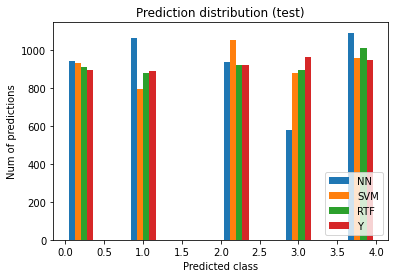

In [46]:
pylab.hist([nn_pred, svm_pred, rtf_pred, true_y],label=['NN','SVM','RTF','Y'])
pylab.legend(loc=4)
pylab.title('Prediction distribution (test)')
pylab.xlabel('Predicted class')
pylab.ylabel('Num of predictions')

On the histogram above we can see that the NN classifier is underclassifying the 3rd class and overclassifying the 1st class, it is not however an unbalanced set problem:

Text(0, 0.5, 'Num of predictions')

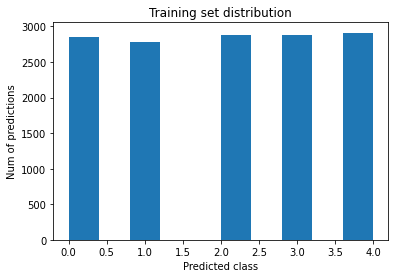

In [47]:
pylab.hist(np.argmax(y_train, axis=1))
pylab.title('Training set distribution')
pylab.xlabel('Predicted class')
pylab.ylabel('Num of predictions')

Accuracies

In [49]:
print(f'NN: {len(np.where(nn_pred==true_y)[0])/len(true_y)}')
print(f'SVM: {len(np.where(svm_pred==true_y)[0])/len(true_y)}')
print(f'RTF: {len(np.where(rtf_pred==true_y)[0])/len(true_y)}')

NN: 0.7936851211072664
SVM: 0.7497837370242214
RTF: 0.7964965397923875


Confusion matrices

In [56]:
import sklearn

nn_cm = sklearn.metrics.confusion_matrix(true_y, nn_pred)
nn_cm

array([[876,   0,   0,   0,  18],
       [  0, 741, 135,   0,  17],
       [  8, 106, 787,   0,  21],
       [  1,  64,   3, 564, 335],
       [ 60, 153,  16,  17, 702]])

In [57]:
svm_cm = sklearn.metrics.confusion_matrix(true_y, svm_pred)
svm_cm

array([[850,   3,  23,   0,  18],
       [ 11, 577, 243,  25,  37],
       [ 55,  89, 708,  29,  41],
       [  0,  39,   2, 696, 230],
       [ 17,  89,  78, 128, 636]])

In [58]:
rtf_cm = sklearn.metrics.confusion_matrix(true_y, rtf_pred)
rtf_cm

array([[853,   0,  10,   0,  31],
       [  1, 672, 145,  17,  58],
       [  8, 118, 732,  13,  51],
       [  2,  48,   5, 734, 178],
       [ 47,  45,  32, 132, 692]])

Precisions

In [79]:
print('NN')
nn_precisions = []

for i in range(5):
  nn_precisions.append(nn_cm[i,i]/nn_cm[:,i].sum())
  print(f'{i}: {nn_precisions[i]}')

print(f'\ngeneral: {sklearn.metrics.precision_score(true_y, nn_pred, average="macro")}')

NN
0: 0.926984126984127
1: 0.6964285714285714
2: 0.8363443145589798
3: 0.9707401032702238
4: 0.6422689844464776

general: 0.8145532201376758


In [80]:
print('SVM')
svm_precisions = []

for i in range(5):
  svm_precisions.append(svm_cm[i,i]/svm_cm[:,i].sum())
  print(f'{i}: {svm_precisions[i]}')

print(f'\ngeneral: {sklearn.metrics.precision_score(true_y, svm_pred, average="macro")}')

SVM
0: 0.9110396570203644
1: 0.7239648682559598
2: 0.6717267552182163
3: 0.7927107061503417
4: 0.6611226611226612

general: 0.7521129295535087


In [81]:
print('RTF')
rtf_precisions = []

for i in range(5):
  rtf_precisions.append(rtf_cm[i,i]/rtf_cm[:,i].sum())
  print(f'{i}: {rtf_precisions[i]}')

print(f'\ngeneral: {sklearn.metrics.precision_score(true_y, rtf_pred, average="macro")}')

RTF
0: 0.9363336992316136
1: 0.7610419026047565
2: 0.7922077922077922
3: 0.8191964285714286
4: 0.6851485148514852

general: 0.7987856674934153


Recalls

In [82]:
print('NN')
nn_recalls = []

for i in range(5):
  nn_recalls.append(nn_cm[i,i]/nn_cm[i].sum())
  print(f'{i}: {nn_recalls[i]}')

print(f'\ngeneral: {sklearn.metrics.recall_score(true_y, nn_pred, average="macro")}')

NN
0: 0.9798657718120806
1: 0.8297872340425532
2: 0.8535791757049892
3: 0.5832471561530507
4: 0.740506329113924

general: 0.7973971333653195


In [83]:
print('SVM')
svm_recalls = []

for i in range(5):
  svm_recalls.append(svm_cm[i,i]/svm_cm[i].sum())
  print(f'{i}: {svm_recalls[i]}')

print(f'\ngeneral: {sklearn.metrics.recall_score(true_y, svm_pred, average="macro")}')

SVM
0: 0.9507829977628636
1: 0.6461366181410975
2: 0.7678958785249458
3: 0.7197518097207859
4: 0.6708860759493671

general: 0.7510906760198119


In [84]:
print('RTF')
rtf_recalls = []

for i in range(5):
  rtf_recalls.append(rtf_cm[i,i]/rtf_cm[i].sum())
  print(f'{i}: {rtf_recalls[i]}')

print(f'\ngeneral: {sklearn.metrics.recall_score(true_y, rtf_pred, average="macro")}')

RTF
0: 0.9541387024608501
1: 0.7525195968645016
2: 0.7939262472885033
3: 0.7590486039296794
4: 0.729957805907173

general: 0.7979181912901415
